# Lecture 11 - Sequence alignments and QC

The purpose of this practical is to have a closer look into sequence alignment, how to troubleshoot bad alignments, and why it is important to look at the data. We will create alignments from different sequence sets to compare alignment algorithms (with and without co-estimation of a phylogenetic tree and the alignment) and we will create phylogenetic trees from each alignment file. At the end, we will compare tree topologies and support and use these trees to help us diagnose the alignments.

You can find the links to the publications associated with each program by clicking on their name.

---

## 1. Setting up the environment

Here, we are installing different alignment programs. The following are "alignment only":
- [muscle](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC390337/)  
- [mafft](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3603318/)  

The next one allows for the co-estimation of a phylogenetic tree and the alignment:
- [bali-phy](https://academic.oup.com/bioinformatics/article/37/18/3032/6156619?guestAccessKey=b1599c90-6c9b-4d78-9b7a-ef1af494d414)  

This one implemments a strategy of finding a seed sequence to use as center of the alignment and then uses tree-like structures to speed up the rest:
- [halign](https://academic.oup.com/mbe/article/39/8/msac166/6653123)  

We are also installing two tools that are widely used for trimming alignments when working with hundreds or thousands of individual alignments. We will discuss whether trimming alignments is appropriate in all cases.
- [trimmal](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2712344/)  
- [clipkit](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001007)

Finally, we will use [IQ-tree](http://www.iqtree.org/doc/) to estimate and compare phylogenetic trees and [CD-HIT](https://sites.google.com/view/cd-hit) to cluster sequences based on identity.

In [ ]:
%%bash

# first, get conda channels up in the list of priority
conda config --add channels conda-forge
conda config --add channels bioconda
conda config --add channels malab

# now, create an environment called phylo with the following packages: iqtree muscle mafft trimal openjdk=11
conda create -n phylo iqtree muscle mafft trimal openjdk=11

# activate the environment
conda activate phylo

# install the rest of the packages we need
conda install -c malab halign
conda install -c bioconda bali-phy
conda install -c bioconda clipkit
conda install -c bioconda cd-hit

In addition to these programs, and outside your Linux subsystem setup (Ubuntu, Linux, bash), you need to install [Jalview](https://www.jalview.org/) to visualise the alignments. Go to [this link](https://www.jalview.org/download/) and the website will automatically suggest the appropriate distribution for your operative system, e.g. for Windows OS it would suggest the Windows distribution and for Linux Fedora it might suggest the Linux 64x distribution.

Once you download the installer file, double click on it and follow the GUI instructions to install the program.

---

## 2. Troubleshooting alignments

Our first dataset is a file that contains the nucleotide sequences of **hemagglutinin**, a receptor-binding membrane fusion glycoprotein produced by viruses in the [Paramyxoviridae](https://en.wikipedia.org/wiki/Paramyxoviridae) family. Viruses within that family can be guilty of annoying (to say the least) diseases in vertebrates - including humans - like mumps, influenza, amongst others. These viruses have non-segmented genomes with several genes that might or might not share homology across the whole family (and other virus). 

A colleague of yours recieved some sequences back from the sequencing facility. Their goal is to reconstruct the path of 

`hemagglutinin.fasta`

First, use two different programs to align the sequences and produce a prelimiary tree to visually understand the relationships (genetic distance) ebtween the sequences you received.

The first alignment program, `muscle`, has two algorithms `-align` and `-super5`, the latest and implementation for dealing with large datasets (you can read more about that [here](https://www.nature.com/articles/s41467-022-34630-w)). The second alignment program, `mafft`, has three algorithms implemented that optimise speed for large datasets (`--globalpair` or `ginsi`) or accuracy at the cost of time (`--localpair` or `linsi`). `mafft` provides a middle ground too (`--genafpair` or `einsi`).

In [ ]:
%%bash

# remember to activate your environment
conda activate phylo

# first, use MUSCLE to align the sequences
muscle -align hemagglutinin.fasta -output hemagglutinin.msl.aln

# now using mafft
mafft --maxiterate 1000 --localpair hemagglutinin.fasta > hemagglutinin.mft.aln

Before we even look at the alignments, let's estimate our draft phylogeny using `iqtree`. For now, we won't worry about the model of nucleotide subsitutions or any partition scheme and will use `-m GTR` as the substitution model. `iqtree` produces several files, of which these ones are relevant right now, e.g.:

**hemagglutinin.mft.it.iqtree** is the file that contains verbose information about the phylogenetic analysis. It includes information about the sequence alignment, the number of *constant sites*, the number of *parsimony informative sites*, and the number of *distinct site patterns*. These three metrics provide useful information about the diversity of the sequences in the alignment and how trully informative they are for infering a phylogeny. The `*.iqtree` file also contains the nucleotide frequencies and substitution rate model parameters, an unrooted phylogeny (oriented by one taxon but that's not equivalent to that taxon being the true outgroup), the same phylogeny in [newick format](https://en.wikipedia.org/wiki/Newick_format), and information about speed and memory used by `iqtree`

**hemagglutinin.mft.it.log** contains the same information that the program prints to STDOUT and includes statistics on each sequence, the log-likelihood of each tree-inference step, information about the search for a better tree (compared to the strating tree), and the log-likelihood of the final "best" phylogeny found.

**hemagglutinin.mft.it.mldist** contains the pairwise distances between sequences based on [Maximum Likelihood](https://en.wikipedia.org/wiki/Computational_phylogenetics#:~:text=Maximum%20Likelihood%20(also%20likelihood)%20optimality,required%20for%20a%20phylogenetic%20tree) estimates (you can make a [heatmap plot]() of it)

**hemagglutinin.mft.it.treefile** contains the final tree in newick format.

In [ ]:
%%bash

iqtree -s hemagglutinin.msl.aln --prefix hemagglutinin.msl.it \
       --seed 42 --seqtype DNA -m GTR

iqtree -s hemagglutinin.mft.aln --prefix hemagglutinin.mft.it \
       --seed 42 --seqtype DNA -m GTR

Let's look a the trees by using [**phylo.io**](beta.phylo.io), an online tool for quick and unedited visualisation of phylogenetic trees. Open a tab on your web browser, access phylo.io, select "compare", and copy-paste both treeson the same box. You can paste the **mafft** tree on the left and the **muscle** tree on the right.

we can also see the trees using [ete toolkit](http://etetoolkit.org/treeview/), although we would have to open a different tab for each tree and we cannot easily compare them.

At first glance, we can tell that the branch lengths are different. We can also tell that the topology is different (remember, both trees are from the same sequences aligned using different programs)

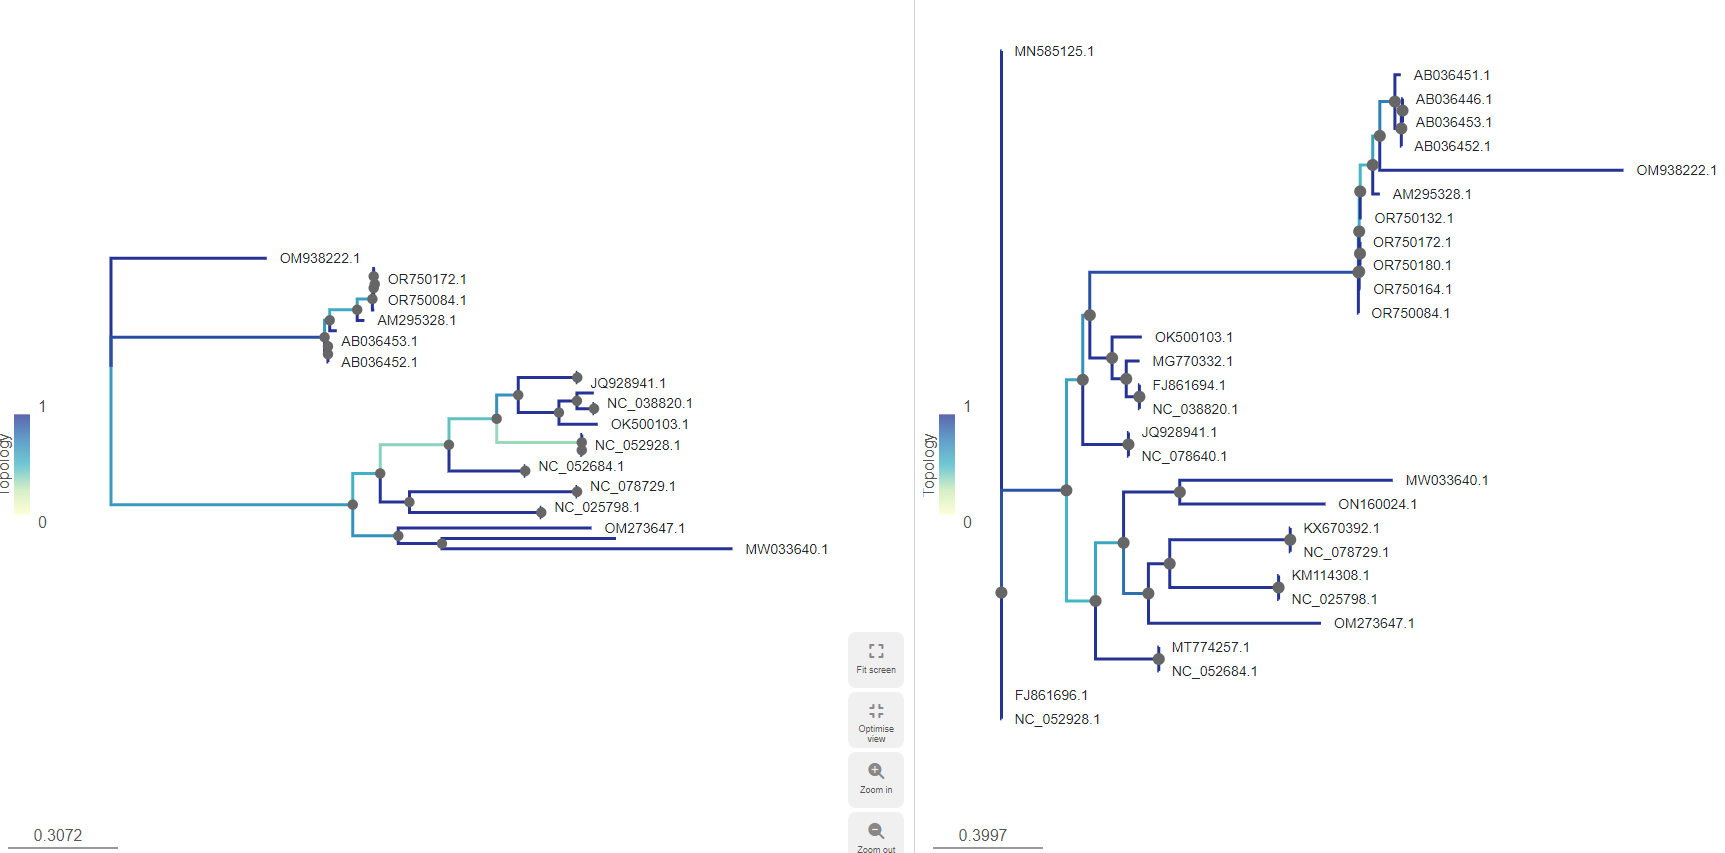

But remember, these are **unrooted** trees and we need to first "position" the root in the same node (keeping in mind that this is only for visualisation purposes and the outgrouping is meaningless). What can you tell about these trees? The topologies are still different but they follow the same patterns. I am suspicios of two different topologies with the same underlaying data when the difference is how the sequences are align. Branch lengths are in units of substitutions per site. **If we are using the exact same substitution rate model, why would the branches have different lengths?**

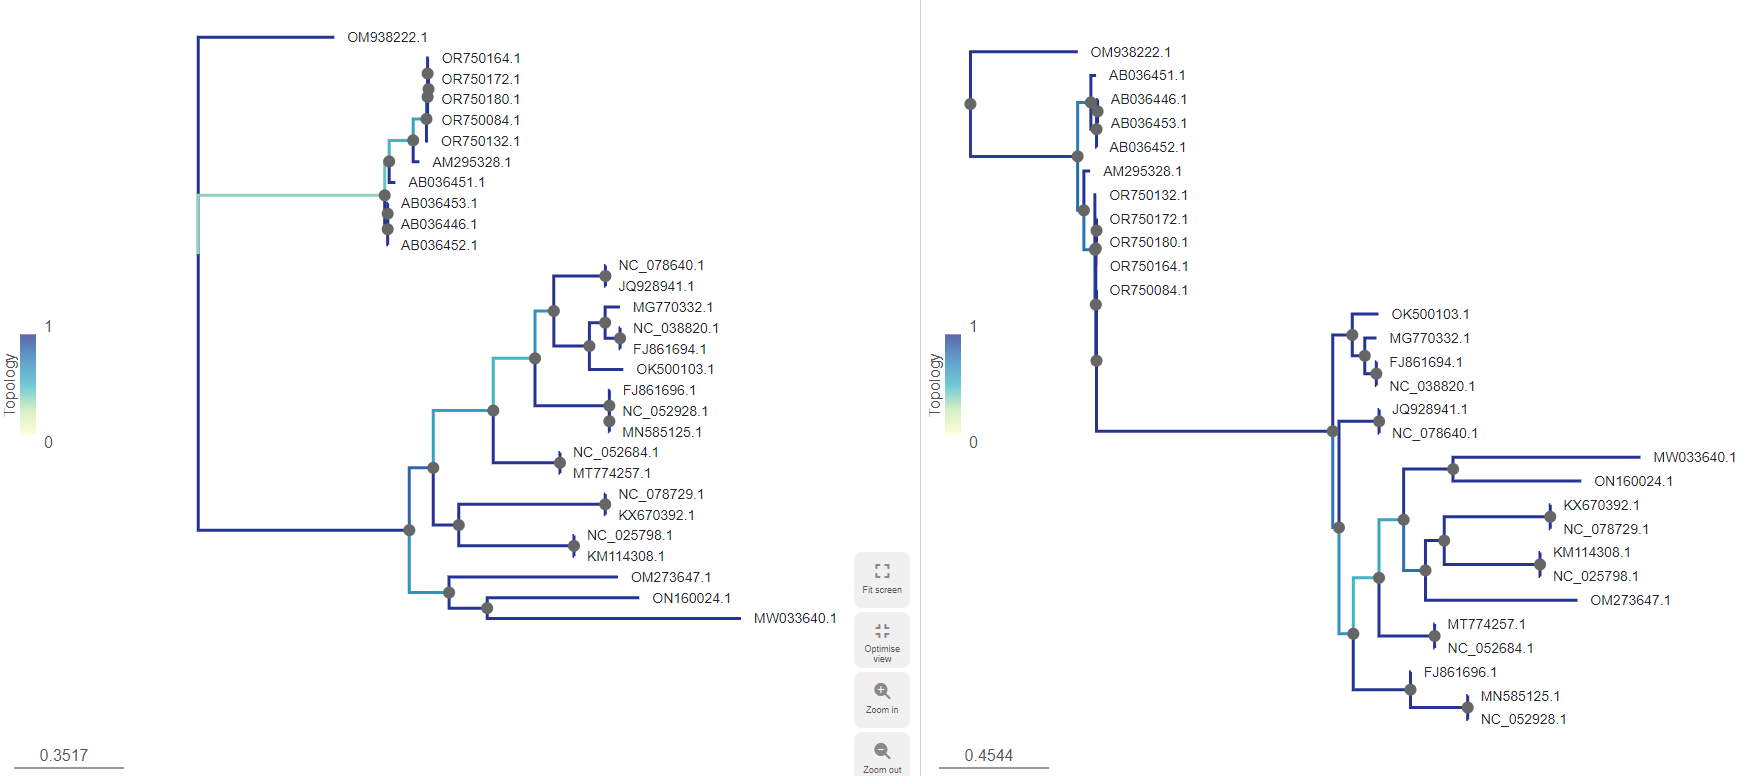

Let's look at the alignments then.

Open Jalview, go to the **File** menu and then to **Input Alignment** and then **From file**. Navigate through your folders and find the alignments. You might need to scroll up **Files of type** to select **All**. You also need to open the alignments one at a time.

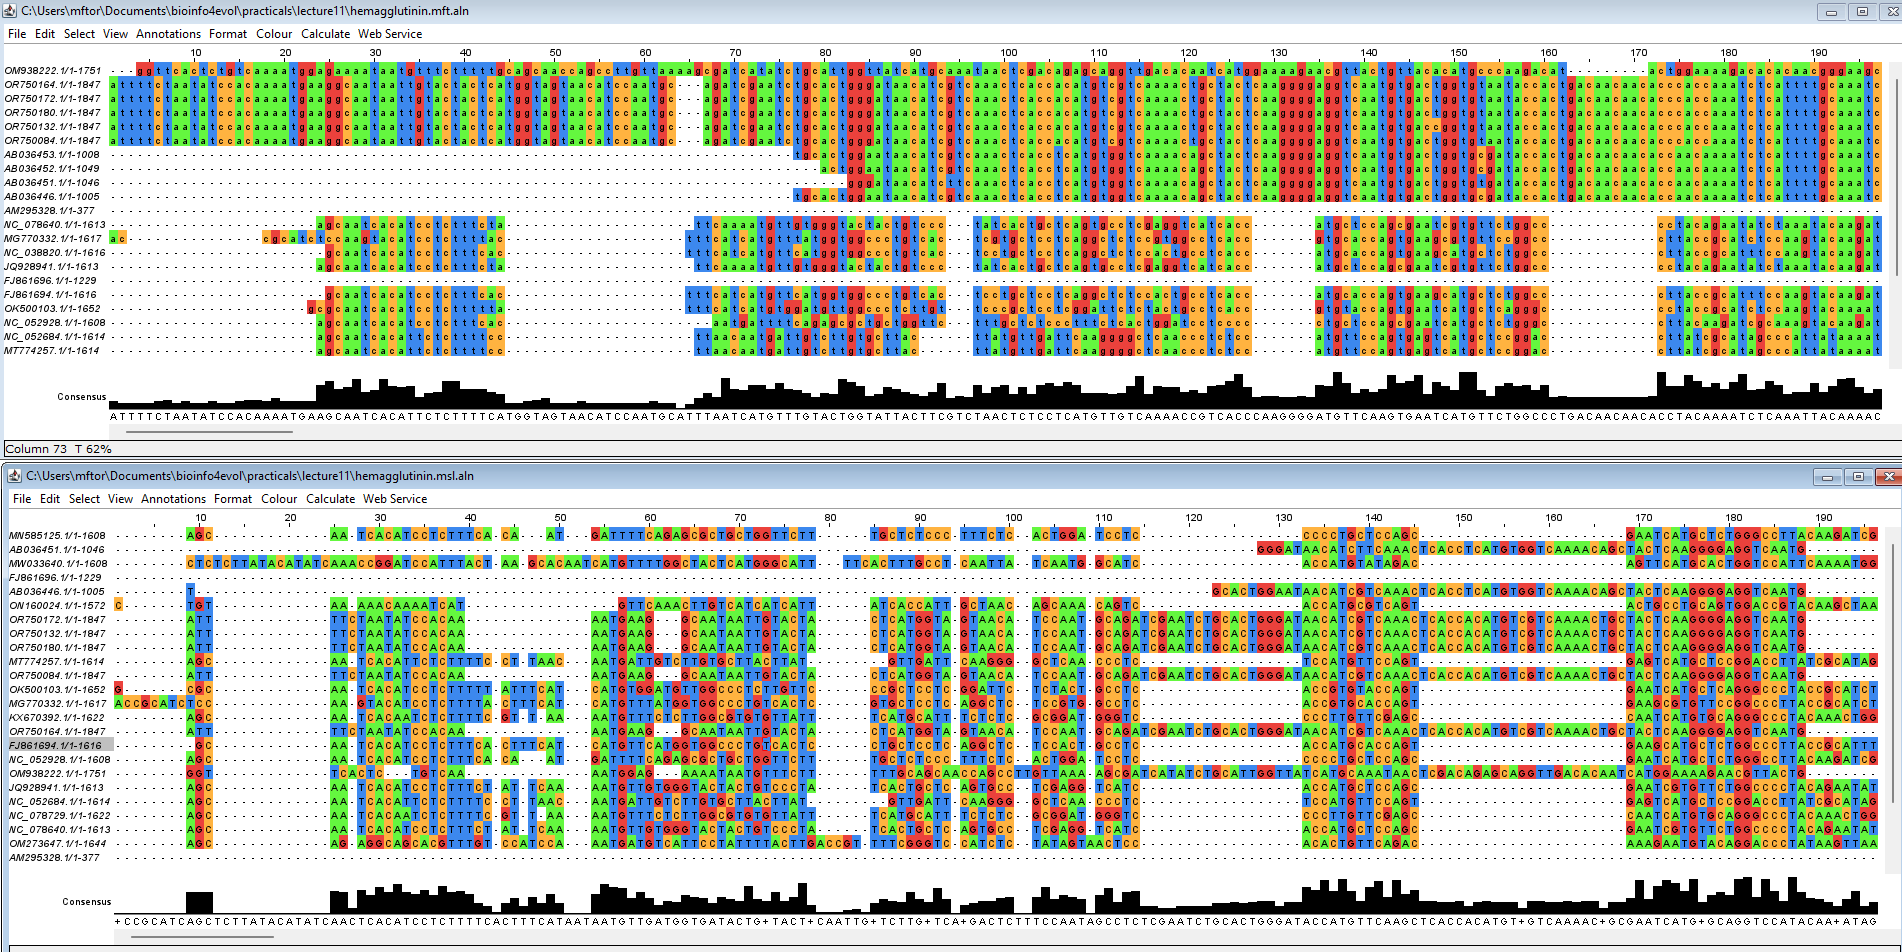

The first look shows that the alignments are quite different (mafft on top; muscle at the bottom) but it might just be that sequences appear in a different order. To order the sequences, go to each alingment windown and select all sequences by hitting **ctrl+a**. Then go to **Calculate** and **Sort** then **By percentage of identity**.

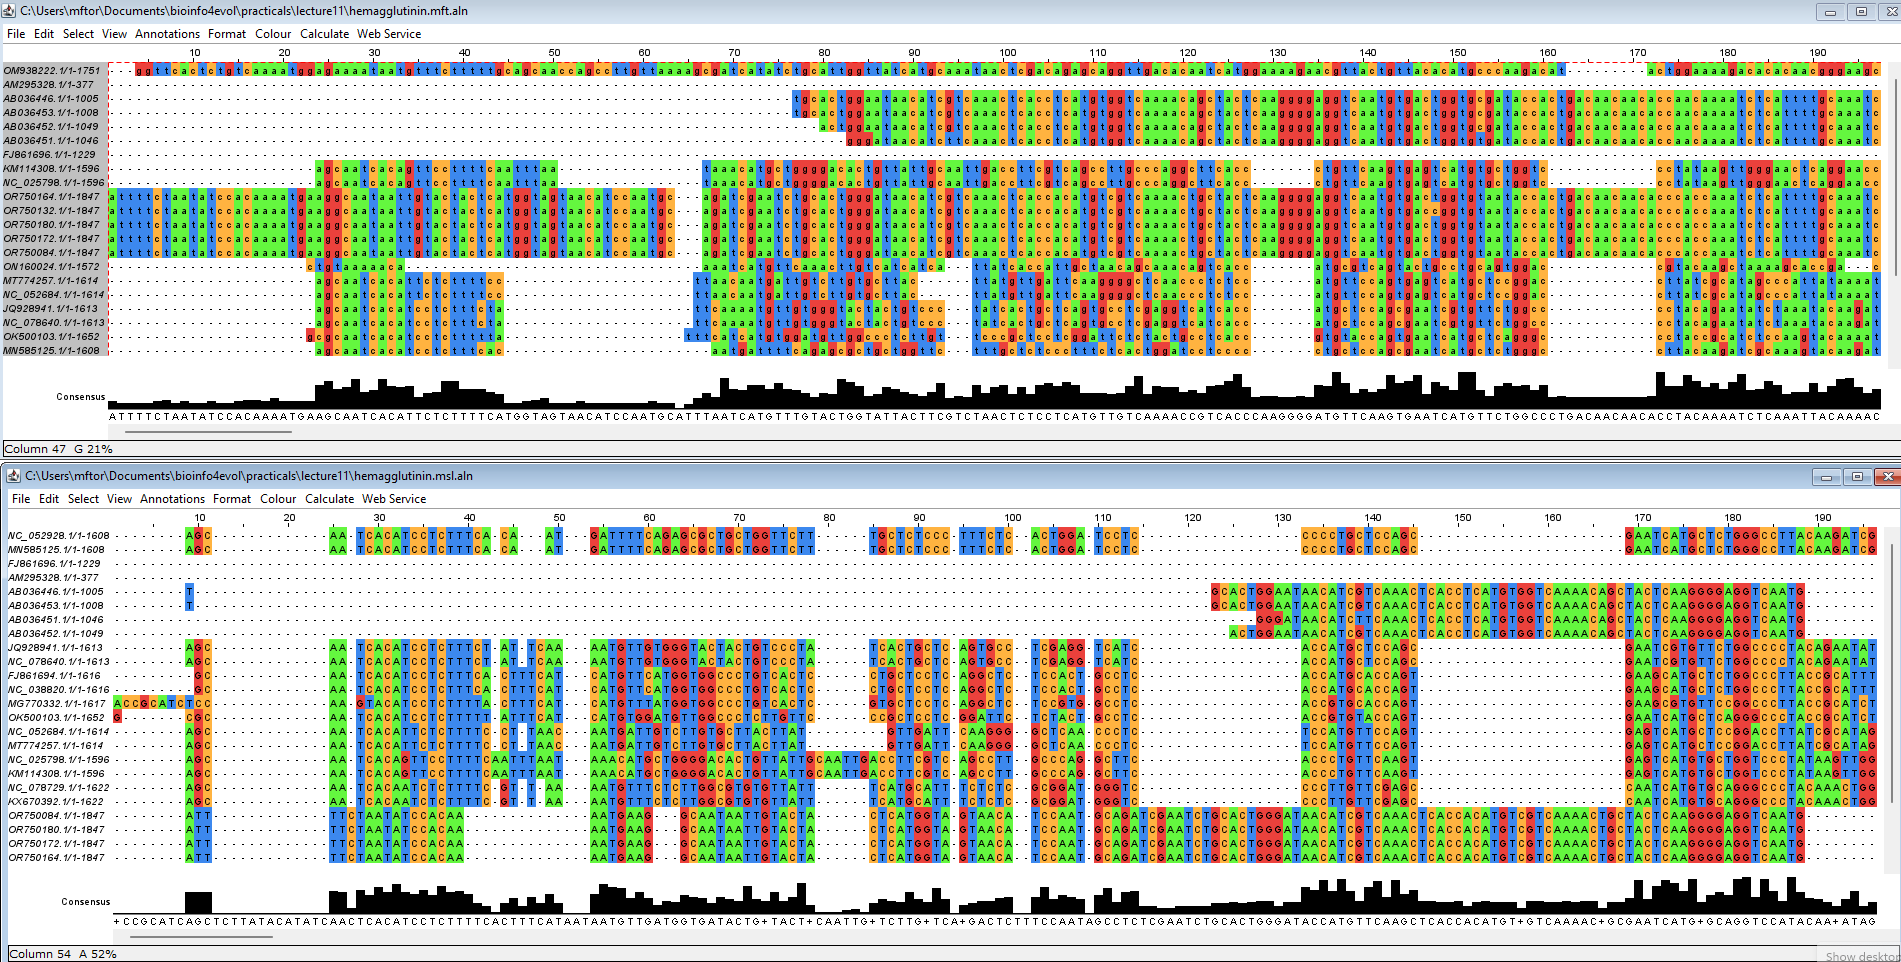

**The alignments are still quite different. What could be happening?**

---

## 3. The use and misuse of alignment trimming programs

Large bioinformatic projects often face the challenge of evaluating hundreds or even thousands of alignments systematically and efficiently. Checking that many alignments is hardly done manually, let alone within a time frame that fits most project's schedules. The gaps (indels?) created by different alignment algorithms will impact the branch length of the tree and might lead to topological errors that do not reflect the true evolutionary story of the taxa included on the tree.

Trimming alignments is meant to reduce noise caused by sequence errors, sequence length differences, hiper-variation at particular sites, and/or ambiguity. Removing the noise focuses on the regions of the alignment that are more conserved or shares a higher percentage of identity. Often, removing noise from the alignments improves the computational efficiency (measured in time, not accuracy) by reducing the landscape of tree topologies thatneeds to be searched during tree inference. It also has the advantage of systematically and reproducibly remove unreliabe regions from the alignments.



---

## 4. Code for implementing your own troubleshooting



In [ ]:
%%bash

# muscle
muscle -align seqdump.txt -output seqdump_muscle.aln

# mafft 
# E-INS-i (Suitable for sequences with long unalignable regions, very slow)
# Iterative refinement method (<16) with LOCAL pairwise alignment with generalized affine gap costs (Altschul 1998)
einsi --maxiterate 1000 --reorder --thread -1 seqdump.txt > seqdump_einsi.aln

# L-INS-i (Probably most accurate, very slow)
# Iterative refinement method (<16) with LOCAL pairwise alignment information
linsi --maxiterate 1000 --reorder --thread -1 seqdump.txt > seqdump_linsi.aln

# G-INS-i (Suitable for sequences of similar lengths, very slow)
# Iterative refinement method (<16) with GLOBAL pairwise alignment information
ginsi --maxiterate 1000 --reorder --thread -1 seqdump.txt > seqdump_ginsi.aln

# you can use halin like this:
halign -o seqdump_halign.aln seqdump.txt

# using Bali-phy the alignment tool that incorporates co-estimation of a phylogeny to improve the aln
# if you cannot install this program in the same environment as the rest you can create its separate environment
# you can access the help by running
bali-phy -h

# check help on the alignments
bali-phy help alphabet

# bal idoesnt like some characters in the sequence names. use send to replace those
sed -i 's/://g' seqdump.txt

# you can use bal-phy to estimate phylogenies from your sequence alignment
# if you dont specify the model with -S bali uses sensible defaults
# -I means we are not indicating a model for insertion deletions
bali-phy -i 2 -A Amino-Acids -n bali_fixedaln -I none --align seqdump.txt
bali-phy -i 2 -A Amino-Acids -n bali_fixedalnmuscle -I none --align seqdump_muscle.txt

# let's do a free alignment using the substitution model -S
# check the models available:
bali-phy help models
# run the alignment
bali-phy -i 2 -A Amino-Acids -n bali_freealn -S lg08+Rates.log_normal[n=4] --align seqdump.txt

# if your alignment has too many sequences you can thin it by removing sequences with --cutoff=5 differences to
# the sequence specified with --preserve=
bali-phy -i 2 -A Amino-Acids -n bali_thined5 -I none --cutoff=5 \
         --preserve=MBC1495633 \
         --align seqdump.txt


# you can trim alingments using clipkit with algorithms that keep informative sites
# you can check the information in clipkit's publication Table 1
# https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001007
# results: Number of sites kept: 231
# results: Number of sites trimmed: 47
# results: Percentage of alignment trimmed: 16.906%
clipkit seqdump_muscle.aln -m kpic-gappy -o seqdump_muscle_clipkit.aln

# you can compare trimming strategies beween clipkit and trimal
# you can run trimal as follows
# the -automated1 algorithm uses a heuristic selection of methods based on similarity
# that are optimised for ML reconstruction
trimal -in seqdump_muscle.aln -automated1 -out seqdump_muscle_trimal.aln

# if you need to remove redundancy from your sequence sets, you can use CD-HIT
# be careful, sequences must be in a single line! not interleaved!
# CD-HIT might also complain about some characters, use sed to remove them
# select the world length depending on the percentage of identity used as threshold to create clusers
# you can see more info here from their manual:

# Choose of word size:
# -n 5 for thresholds 0.7 ~ 1.0
# -n 4 for thresholds 0.6 ~ 0.7
# -n 3 for thresholds 0.5 ~ 0.6
# -n 2 for thresholds 0.4 ~ 0.5 

# -S (for aminoacids) is the length dfference cutoff (clustered sequences must be at least x% the length of the 
# representative sequence of the cluster)
# here I want to remove very similar sequences to reduce the size of the dataset
# and speed up the tree
# you can add the remaining sequences after tree inference with RAxML
# 199 clusters in my data
# here, the txt file contains the sequences representative for each cluster (one per cluster)
cd-hit -i seqdump.txt -o seqdump_cdhit98.txt -n 5 -S 0 -c 0.98

# here I am assuming my dataset might contain sets of non-homologous sequences
# I am clustering them by >50% identity to analise them separatedly
# 45 clusters in my data
# in this case, I need to go to the file with cluster (*.clstr) information and use grep to extract the sequences for each cluster
# redirecting those sequences to a separate fasta file
cd-hit -i seqdump.txt -o seqdump_cdhit50.txt -n 2 -S 0 -c 0.50
